In [58]:
import math
from statistics import mean

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text

raw_set_data = pd.read_csv("X023_set_export.csv")
# let's have a quick peek at the dataframe 
columns_of_interest = [
    "set_number", "start_date", "end_date", 'start_latitude_DD',
    'start_latitude_MMmm', 'start_longitude_DD', 'start_longitude_MMmm', 'end_latitude_DD',
    'end_latitude_MMmm', 'end_longitude_DD', 'end_longitude_MMmm', "set_result", "id"
]
raw_set_data[columns_of_interest].head()

,set_number,start_date,end_date,start_latitude_DD,start_latitude_MMmm,start_longitude_DD,start_longitude_MMmm,end_latitude_DD,end_latitude_MMmm,end_longitude_DD,end_longitude_MMmm,set_result,id
0,1,2023-06-20 14:48:42 UTC,2023-06-21 09:23:20 UTC,46,NaN,-64,NaN,46.0,NaN,-64.0,NaN,1 - NORMAL - No damage to gear,344
1,2,2023-06-20 14:55:00 UTC,2023-06-21 09:41:42 UTC,46,NaN,-64,NaN,46.0,NaN,-64.0,NaN,1 - NORMAL - No damage to gear,345
2,3,2023-06-20 15:00:54 UTC,2023-06-21 09:51:54 UTC,46,49.39991,-64,18.45374,46.0,49.40960,-64.0,18.40501,1 - NORMAL - No damage to gear,346
3,4,2023-06-20 15:08:17 UTC,2023-06-21 10:00:29 UTC,46,NaN,-64,NaN,46.0,NaN,-64.0,NaN,1 - NORMAL - No damage to gear,347
4,5,2023-06-20 15:14:13 UTC,2023-06-21 10:11:03 UTC,46,46.83280,-64,22.06068,46.0,46.85389,-64.0,22.02738,1 - NORMAL - No damage to gear,348


### Let's do a bit of cleanup to the Set data

In [59]:
def dm2dd(d, m, longitude=False):
    """function to convert degree minutes to decimal degrees"""
    if d < 0:
        d = -d
    if m < 0:
        m = -m
    my_coord = float(d) + float(m) / 60
    return -my_coord if longitude else my_coord


# convert DDMM to dec deg
raw_set_data["start_latitude"] = raw_set_data.apply(lambda x: dm2dd(x["start_latitude_DD"], x["start_latitude_MMmm"], False), axis=1)
raw_set_data["start_longitude"] = raw_set_data.apply(lambda x: dm2dd(x["start_longitude_DD"], x["start_longitude_MMmm"], True), axis=1)
raw_set_data["end_latitude"] = raw_set_data.apply(lambda x: dm2dd(x["end_latitude_DD"], x["end_latitude_MMmm"], False), axis=1)
raw_set_data["end_longitude"] = raw_set_data.apply(lambda x: dm2dd(x["end_longitude_DD"], x["end_longitude_MMmm"], True), axis=1)

# centroids
raw_set_data["centroid_latitude"] = raw_set_data.apply(lambda x: mean([x["start_latitude"], x["end_latitude"]]), axis=1)
raw_set_data["centroid_longitude"] = raw_set_data.apply(lambda x: mean([x["start_longitude"], x["end_longitude"]]), axis=1)

# datetime string to datetime objects
raw_set_data["start_date"] = pd.to_datetime(raw_set_data["start_date"], utc=True).dt.tz_convert('Canada/Atlantic')
raw_set_data["end_date"] = pd.to_datetime(raw_set_data["end_date"], utc=True).dt.tz_convert('Canada/Atlantic')

# add some columns to help identify problematic sets
def is_valid(*args) -> bool:
    for item in args:
        if not bool(item) or np.isnan(item):
            return False
    return True


raw_set_data["has_start_coordinates"] = raw_set_data.apply(lambda x: is_valid(x["start_latitude"], x["start_longitude"]), axis=1)
raw_set_data["has_end_coordinates"] = raw_set_data.apply(lambda x: is_valid(x["end_latitude"], x["end_longitude"]), axis=1)

columns_of_interest = ["set_number", "start_date", "end_date", 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'centroid_latitude',
                       'centroid_longitude', 'id', "set_result",
                       "has_start_coordinates", "has_end_coordinates"]
sets = raw_set_data[columns_of_interest]
sets

,set_number,start_date,end_date,start_latitude,start_longitude,end_latitude,end_longitude,centroid_latitude,centroid_longitude,id,set_result,has_start_coordinates,has_end_coordinates
0,1,2023-06-20 11:48:42-03:00,2023-06-21 06:23:20-03:00,NaN,NaN,NaN,NaN,NaN,NaN,344,1 - NORMAL - No damage to gear,False,False
1,2,2023-06-20 11:55:00-03:00,2023-06-21 06:41:42-03:00,NaN,NaN,NaN,NaN,NaN,NaN,345,1 - NORMAL - No damage to gear,False,False
2,3,2023-06-20 12:00:54-03:00,2023-06-21 06:51:54-03:00,46.823332,-64.307562,46.823493,-64.306750,46.823413,-64.307156,346,1 - NORMAL - No damage to gear,True,True
3,4,2023-06-20 12:08:17-03:00,2023-06-21 07:00:29-03:00,NaN,NaN,NaN,NaN,NaN,NaN,347,1 - NORMAL - No damage to gear,False,False
4,5,2023-06-20 12:14:13-03:00,2023-06-21 07:11:03-03:00,46.780547,-64.367678,46.780898,-64.367123,46.780722,-64.367401,348,1 - NORMAL - No damage to gear,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,840,2023-08-03 15:42:21-03:00,2023-08-04 13:22:02-03:00,47.986985,-65.849799,47.987216,-65.849069,47.987101,-65.849434,1194,NaN,True,True
840,841,2023-08-03 15:59:04-03:00,2023-08-04 13:38:45-03:00,48.008850,-65.822309,48.007776,-65.820893,48.008313,-65.821601,1195,NaN,True,True
841,842,2023-08-03 16:09:51-03:00,2023-08-04 13:46:45-03:00,47.987321,-65.787154,47.987620,-65.786459,47.987470,-65.786806,1196,NaN,True,True
842,843,2023-08-03 16:18:56-03:00,2023-08-04 13:57:09-03:00,47.967994,-65.753419,47.968229,-65.752661,47.968111,-65.753040,1198,1 - NORMAL - No damage to gear,True,True


In [60]:
# Let's find sets with missing coordinates
print("missing both:", sets[((sets["has_start_coordinates"] == False) & (sets["has_end_coordinates"] == False))]["set_number"].to_list())  # missing both
print("missing start:", sets[((sets["has_start_coordinates"] == False) & (sets["has_end_coordinates"] == True))]["set_number"].to_list())  # missing start
print("missing end:", sets[((sets["has_start_coordinates"] == True) & (sets["has_end_coordinates"] == False))]["set_number"].to_list())  # missing end


missing both: [1, 2, 4]
missing start: [91, 453, 802]
missing end: [51, 133, 257, 269, 278, 335, 640, 731]




| Set number | Missing Start Coordinate | Missing End Coordinate |
|------------|--------------------------|------------------------|
| 1          | Yes                      | Yes                    |
| 2          | Yes                      | Yes                    |
| 4          | Yes                      | Yes                    |
| 91         | Yes                      |                      |
| 453        | Yes                      |                      |
| 802        | Yes                      |                      |
|    51     |                        | Yes                    |
|    133     |                       | Yes                    |
|    257     |                        | Yes                    |
|    269     |                        | Yes                    |
|    278     |                        | Yes                    |
|    335     |                        | Yes                    |
|    640     |                        | Yes                    |
|    731     |                        | Yes                    |


### We will have to deal with the above coordinates separately. For now, we exclude them from the analysis


In [61]:
mask = ((sets["has_start_coordinates"] == True) & (sets["has_end_coordinates"] == True))
full_sets = sets[mask].copy(deep=True)
print(full_sets.shape)

(830, 13)


### The resulting dataframe is 830 observations

Now let's have a quick look at the distances between start end end coordinates and we'll see if we can spot some outliers


In [62]:
# it would be interesting to look at the set distances
def calc_nautical_dist(p0, p1):
    """
    p0 and p1 should be dicts with key 'lat' and 'lng'
    """
    try:
        nautical_miles = 3443.8985 * math.acos(
            math.sin(p0["lat"] * math.pi / 180) * math.sin(p1["lat"] * math.pi / 180) +
            math.cos(p0["lat"] * math.pi / 180) * math.cos(p1["lat"] * math.pi / 180) *
            math.cos(p1["lng"] * math.pi / 180 - p0["lng"] * math.pi / 180)
        )
        return nautical_miles
    except:
        pass


full_sets["distance"] = sets.apply(
    lambda x: calc_nautical_dist({"lat": x["start_latitude"], "lng": x["start_longitude"]}, {"lat": x["end_latitude"], "lng": x["end_longitude"]}), axis=1)

# while we are at it, let's calculate set durations
full_sets["duration"] = sets.apply(
    lambda x: ((x["end_date"] - x["start_date"]).seconds + ((x["end_date"] - x["start_date"]).days * 24 * 60 * 60)) / 3600, axis=1)




(-100.0, 850.0)

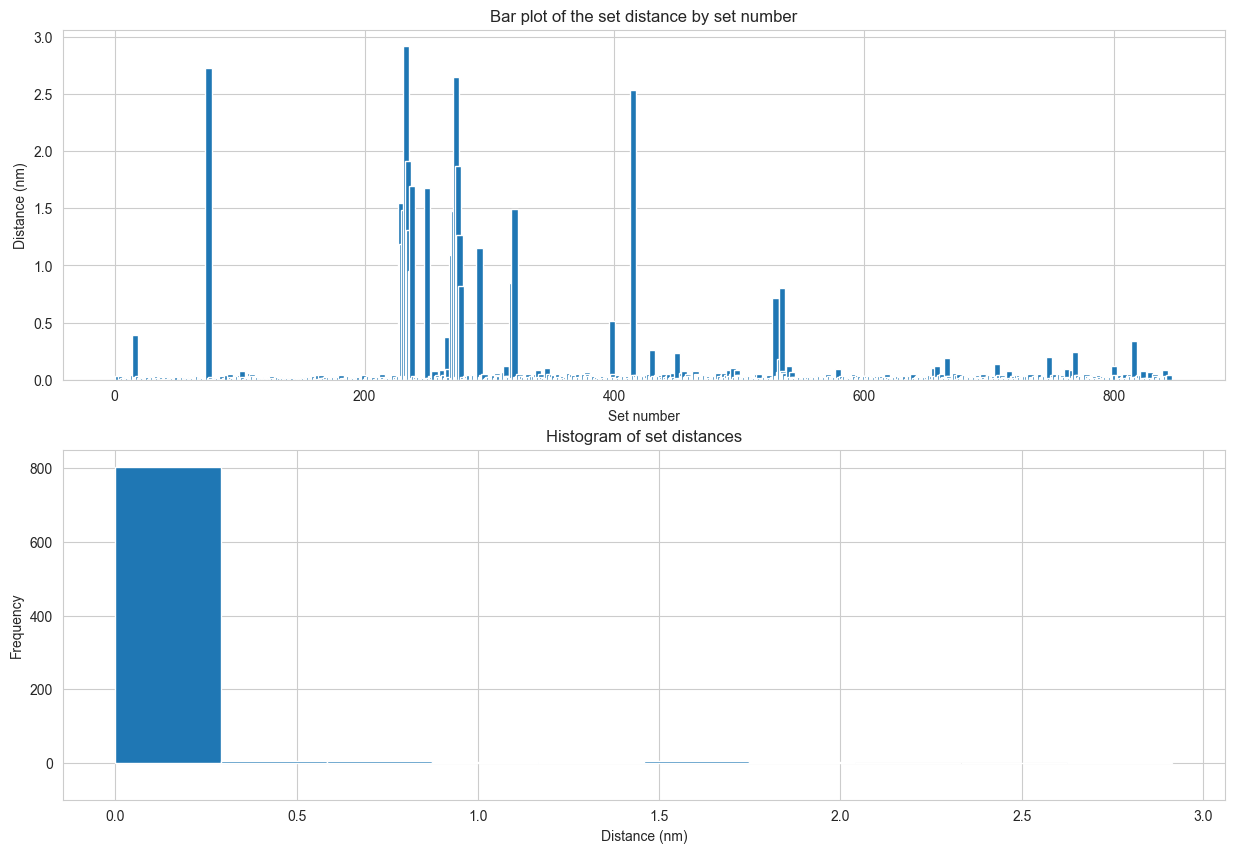

In [63]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.bar(full_sets["set_number"], full_sets["distance"], width=5)
plt.title("Bar plot of the set distance by set number")
plt.xlabel("Set number")
plt.ylabel("Distance (nm)")

plt.subplot(2, 1, 2)
hist = plt.hist(full_sets["distance"])
plt.title("Histogram of set distances")
plt.xlabel("Distance (nm)")
plt.ylabel("Frequency")
plt.ylim(-100, 850)


In [64]:
print(hist[0])
print(hist[1])


[804.   4.   4.   3.   3.   6.   2.   0.   1.   3.]
[0.         0.29150267 0.58300534 0.87450801 1.16601069 1.45751336
 1.74901603 2.0405187  2.33202137 2.62352404 2.91502671]


### In the above, we can the vast majority of set distances range between 0 to 0.29 nm,  exclusively.

### Let's do the same for set duration

Text(0, 0.5, 'Frequency')

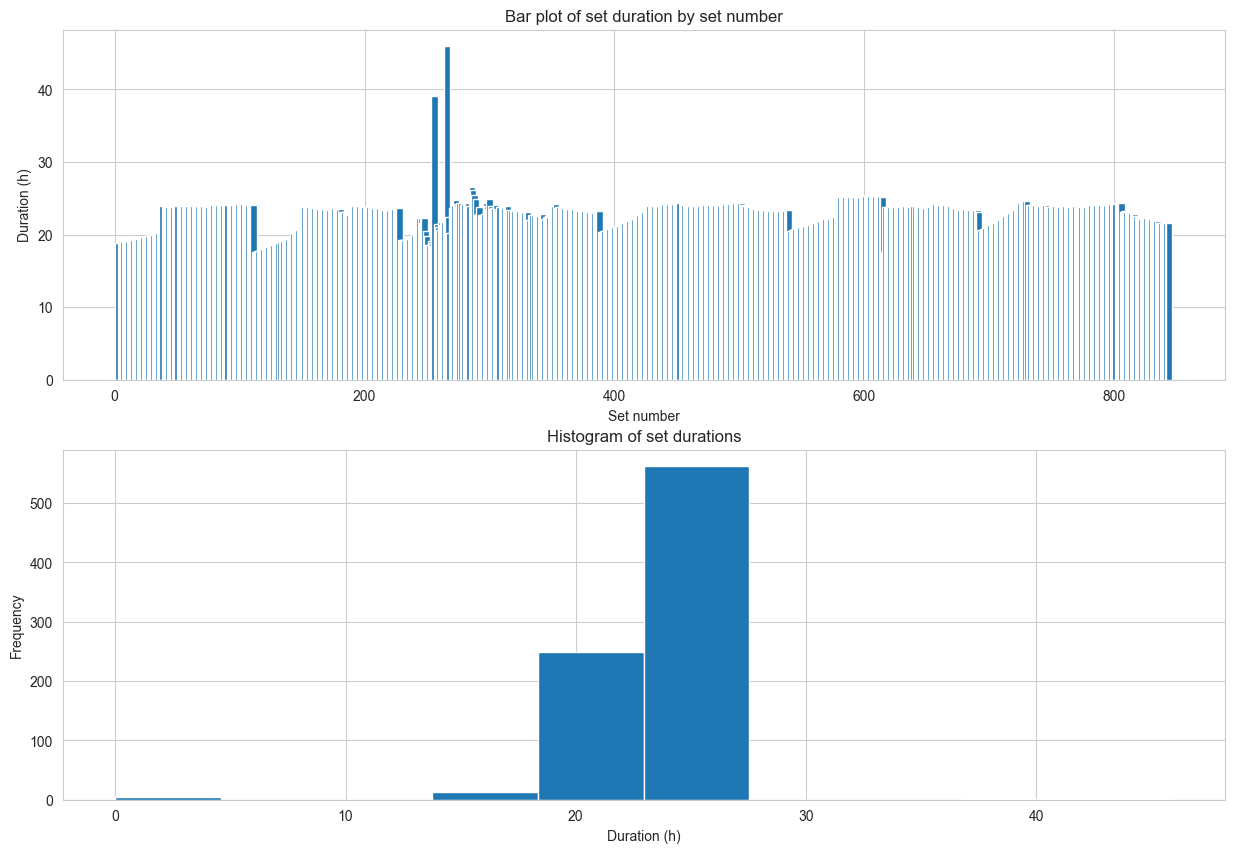

In [65]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.bar(full_sets["set_number"], full_sets["duration"], width=5)
plt.title("Bar plot of set duration by set number")
plt.xlabel("Set number")
plt.ylabel("Duration (h)")

plt.subplot(2, 1, 2)
hist = plt.hist(full_sets["duration"])
plt.title("Histogram of set durations")
plt.xlabel("Duration (h)")
plt.ylabel("Frequency")


### There are a couple of really long sets.. and a few really short ones

In [66]:
# let's see the sets where duration is greater than 30 hours
mask = full_sets["duration"] > 30
full_sets[mask]

,set_number,start_date,end_date,start_latitude,start_longitude,end_latitude,end_longitude,centroid_latitude,centroid_longitude,id,set_result,has_start_coordinates,has_end_coordinates,distance,duration
255,256,2023-07-10 15:17:11-03:00,2023-07-12 06:20:31-03:00,45.885771,-62.712151,45.886008,-62.713889,45.885890,-62.71302,608,NaN,True,True,0.074073,39.055556
265,266,2023-07-10 16:55:52-03:00,2023-07-12 14:50:40-03:00,45.950743,-62.858433,45.952349,-62.867128,45.951546,-62.86278,618,NaN,True,True,0.375941,45.913333


Perhaps these was some bad weather on July 11? 

In [67]:
# let's see the sets where duration is greater than 30 hours
mask = full_sets["duration"] < 15
full_sets[mask]

,set_number,start_date,end_date,start_latitude,start_longitude,end_latitude,end_longitude,centroid_latitude,centroid_longitude,id,set_result,has_start_coordinates,has_end_coordinates,distance,duration
38,39,2023-06-22 06:23:34-03:00,2023-06-22 06:23:40-03:00,46.856010,-64.264673,46.855968,-64.264709,46.855989,-64.264691,382,NaN,True,True,0.002952,0.001667
284,285,2023-07-11 09:38:41-03:00,2023-07-11 09:38:43-03:00,45.869081,-62.743721,45.869081,-62.743721,45.869081,-62.743721,637,NaN,True,True,0.000000,0.000556
308,309,2023-07-12 05:49:14-03:00,2023-07-12 05:49:17-03:00,45.909354,-62.744882,45.909357,-62.744893,45.909356,-62.744888,662,NaN,True,True,0.000495,0.000833
317,318,2023-07-12 07:56:08-03:00,2023-07-12 08:03:20-03:00,45.805372,-62.723992,45.796144,-62.739359,45.800758,-62.731676,671,NaN,True,True,0.849905,0.120000


### These are weird but they are from around the same time period. Maybe a weather-related explanation?  

@Andrew, it is too bad that you guys are not using the `Set Result` field. How were you indicating a failed set?  


### Let's take a closer look at the sets whose distances are greater than 0.2 nm  

In [68]:
# let's get a list of sets whose distances are greater than 10

mask = full_sets["distance"] > 0.2
sus_sets = full_sets[mask]

print(sus_sets.shape)
sus_sets

(29, 15)


,set_number,start_date,end_date,start_latitude,start_longitude,end_latitude,end_longitude,centroid_latitude,centroid_longitude,id,set_result,has_start_coordinates,has_end_coordinates,distance,duration
15,16,2023-06-20 13:28:05-03:00,2023-06-21 08:48:09-03:00,46.846854,-64.391517,46.842294,-64.398450,46.844574,-64.394983,359,1 - NORMAL - No damage to gear,True,True,0.395430,19.334444
74,75,2023-06-22 06:34:20-03:00,2023-06-23 06:22:50-03:00,46.834092,-64.292130,46.866251,-64.245466,46.850172,-64.268798,422,NaN,True,True,2.723280,23.808333
228,229,2023-07-10 10:27:05-03:00,2023-07-11 05:40:36-03:00,45.926367,-62.769499,45.927975,-62.732589,45.927171,-62.751044,581,NaN,True,True,1.546195,19.225278
229,230,2023-07-10 10:38:21-03:00,2023-07-11 05:55:46-03:00,45.928087,-62.731852,45.910066,-62.743572,45.919076,-62.737712,582,NaN,True,True,1.188903,19.290278
231,232,2023-07-10 11:15:44-03:00,2023-07-11 06:31:23-03:00,45.877556,-62.679575,45.885883,-62.712869,45.881719,-62.696222,584,NaN,True,True,1.480335,19.260833
232,233,2023-07-10 11:30:13-03:00,2023-07-11 06:45:53-03:00,45.829740,-62.678926,45.878236,-62.679372,45.853988,-62.679149,585,NaN,True,True,2.915027,19.261111
234,235,2023-07-10 11:53:58-03:00,2023-07-11 07:16:08-03:00,45.826959,-62.723614,45.829953,-62.678245,45.828456,-62.700929,587,NaN,True,True,1.908689,19.369444
235,236,2023-07-10 12:06:23-03:00,2023-07-11 07:30:00-03:00,45.805389,-62.723997,45.827159,-62.723749,45.816274,-62.723873,588,NaN,True,True,1.308579,19.393611
236,237,2023-07-10 12:11:57-03:00,2023-07-11 07:40:09-03:00,45.796001,-62.741466,45.805658,-62.723397,45.800830,-62.732432,589,NaN,True,True,0.954049,19.470000
237,238,2023-07-10 12:23:17-03:00,2023-07-11 07:49:39-03:00,45.771854,-62.720329,45.796203,-62.740803,45.784029,-62.730566,590,NaN,True,True,1.696621,19.439444


## There are 29 sets identified worth inspecting

@Andrew, it would be nice if you guys had the LFAs in Andes

<Axes: xlabel='centroid_longitude', ylabel='centroid_latitude'>

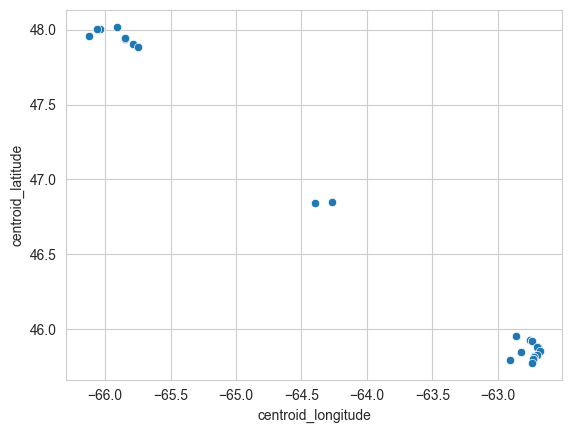

In [69]:
sns.scatterplot(data=sus_sets, x="centroid_longitude", y="centroid_latitude")

There are three groups of sets. Let's look at each one more carefully

In [70]:
# carve out the points based on y axis
group1 = sus_sets[(sus_sets["centroid_latitude"] > 45) & (sus_sets["centroid_latitude"] < 46.5)]
group2 = sus_sets[(sus_sets["centroid_latitude"] > 46.5) & (sus_sets["centroid_latitude"] < 47.5)]
group3 = sus_sets[(sus_sets["centroid_latitude"] > 47.5) & (sus_sets["centroid_latitude"] < 50)]


## Closer inspection of Cluster 3


14

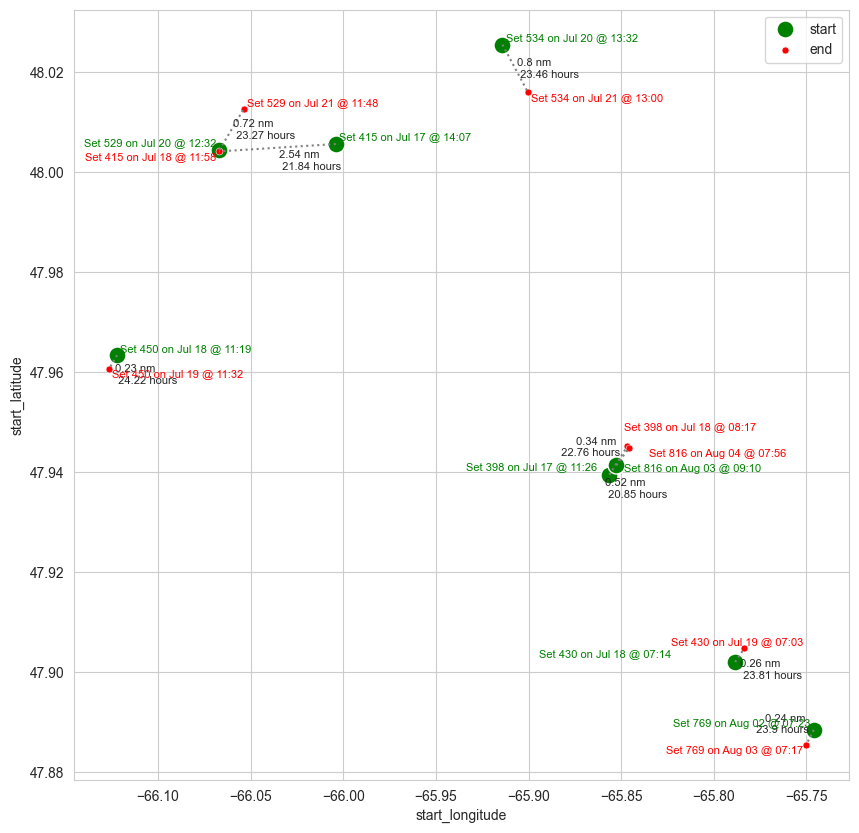

In [71]:
plt.figure(figsize=(10, 10))

sns.scatterplot(data=group3, x="start_longitude", y="start_latitude", color="g", label="start", s=150)
sns.scatterplot(data=group3, x="end_longitude", y="end_latitude", color="r", label="end", s=25)
texts = list()
for index, row in group3.iterrows():
    texts.append(
        plt.text(x=row["centroid_longitude"], y=row["centroid_latitude"], font={'size': 8},
                 s=f'{round(row["distance"], 2)} nm \n {round(row["duration"], 2)} hours')
    )
    texts.append(
        plt.text(x=row["start_longitude"], y=row["start_latitude"], color="g", font={'size': 8},
                 s=f'Set {row["set_number"]} on {row["start_date"].strftime("%b %d @ %H:%M")}')
    )

    texts.append(
        plt.text(x=row["end_longitude"], y=row["end_latitude"], color="r", font={'size': 8},
                 s=f'Set {row["set_number"]} on {row["end_date"].strftime("%b %d @ %H:%M")}')
    )

    plt.plot((row["start_longitude"], row["end_longitude"]), (row["start_latitude"], row["end_latitude"]), c="grey", linestyle=":")
adjust_text(texts)


#### Everything looks copacetic here!!  

## Closer inspection of Cluster 2



6

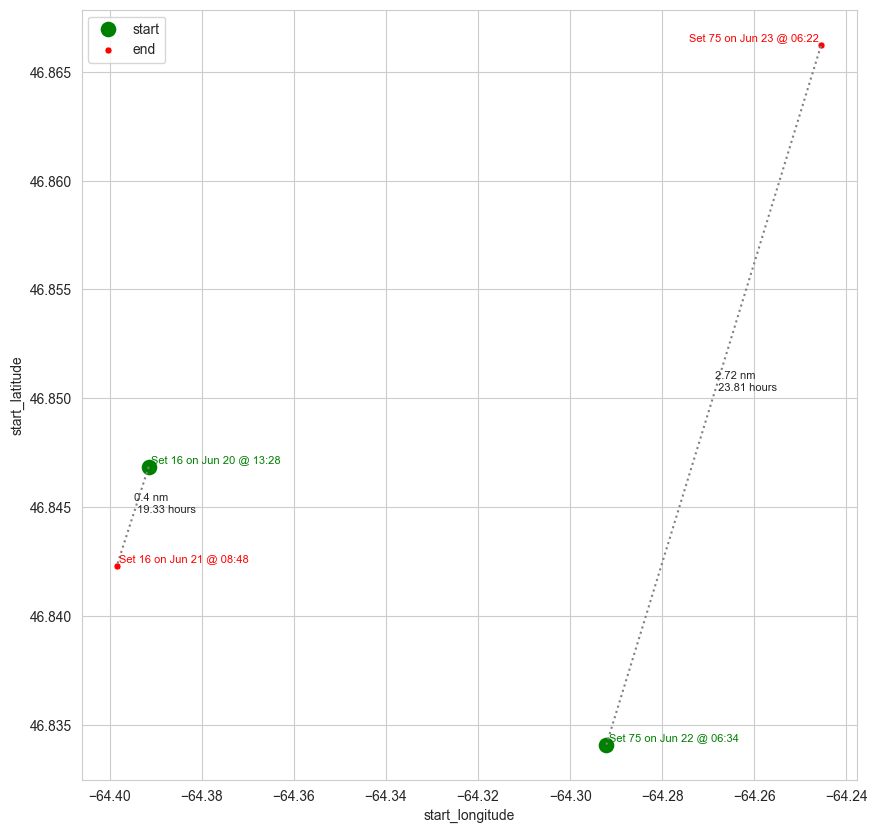

In [72]:
plt.figure(figsize=(10, 10))

sns.scatterplot(data=group2, x="start_longitude", y="start_latitude", color="g", label="start", s=150)
sns.scatterplot(data=group2, x="end_longitude", y="end_latitude", color="r", label="end", s=25)
texts = list()
for index, row in group2.iterrows():
    texts.append(
        plt.text(x=row["centroid_longitude"], y=row["centroid_latitude"], font={'size': 8},
                 s=f'{round(row["distance"], 2)} nm \n {round(row["duration"], 2)} hours')
    )
    texts.append(
        plt.text(x=row["start_longitude"], y=row["start_latitude"], color="g", font={'size': 8},
                 s=f'Set {row["set_number"]} on {row["start_date"].strftime("%b %d @ %H:%M")}')
    )

    texts.append(
        plt.text(x=row["end_longitude"], y=row["end_latitude"], color="r", font={'size': 8},
                 s=f'Set {row["set_number"]} on {row["end_date"].strftime("%b %d @ %H:%M")}')
    )

    plt.plot((row["start_longitude"], row["end_longitude"]), (row["start_latitude"], row["end_latitude"]), c="grey", linestyle=":")
adjust_text(texts)


### The durations seem to be reasonable. By why is the distance so large on Set 75? 


Is a drift of 2.72 NM even possible? Seems like a lot!

## Closer inspection of Cluster 1

Looks like a mess :(

80

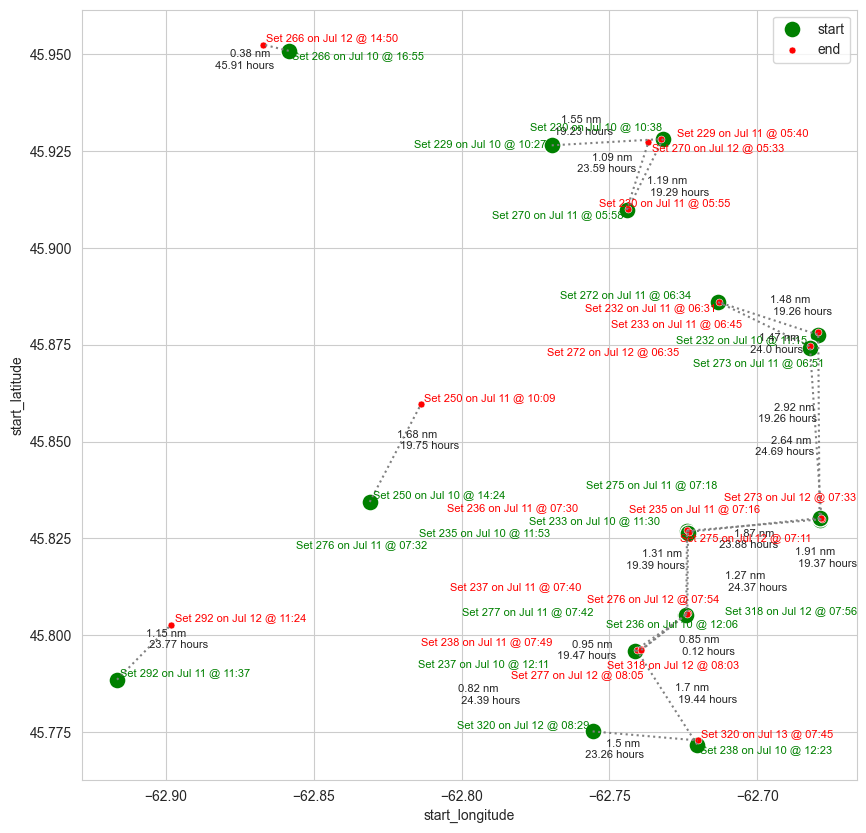

In [73]:
plt.figure(figsize=(10, 10))

sns.scatterplot(data=group1, x="start_longitude", y="start_latitude", color="g", label="start", s=150)
sns.scatterplot(data=group1, x="end_longitude", y="end_latitude", color="r", label="end", s=25)
texts = list()
for index, row in group1.iterrows():
    texts.append(
        plt.text(x=row["centroid_longitude"], y=row["centroid_latitude"], font={'size': 8},
                 s=f'{round(row["distance"], 2)} nm \n {round(row["duration"], 2)} hours')
    )
    texts.append(
        plt.text(x=row["start_longitude"], y=row["start_latitude"], color="g", font={'size': 8},
                 s=f'Set {row["set_number"]} on {row["start_date"].strftime("%b %d @ %H:%M")}')
    )
    texts.append(
        plt.text(x=row["end_longitude"], y=row["end_latitude"], color="r", font={'size': 8},
                 s=f'Set {row["set_number"]} on {row["end_date"].strftime("%b %d @ %H:%M")}')
    )

    plt.plot((row["start_longitude"], row["end_longitude"]), (row["start_latitude"], row["end_latitude"]), c="grey", linestyle=":")
adjust_text(texts)


This cluster is a real... cluster. 



500

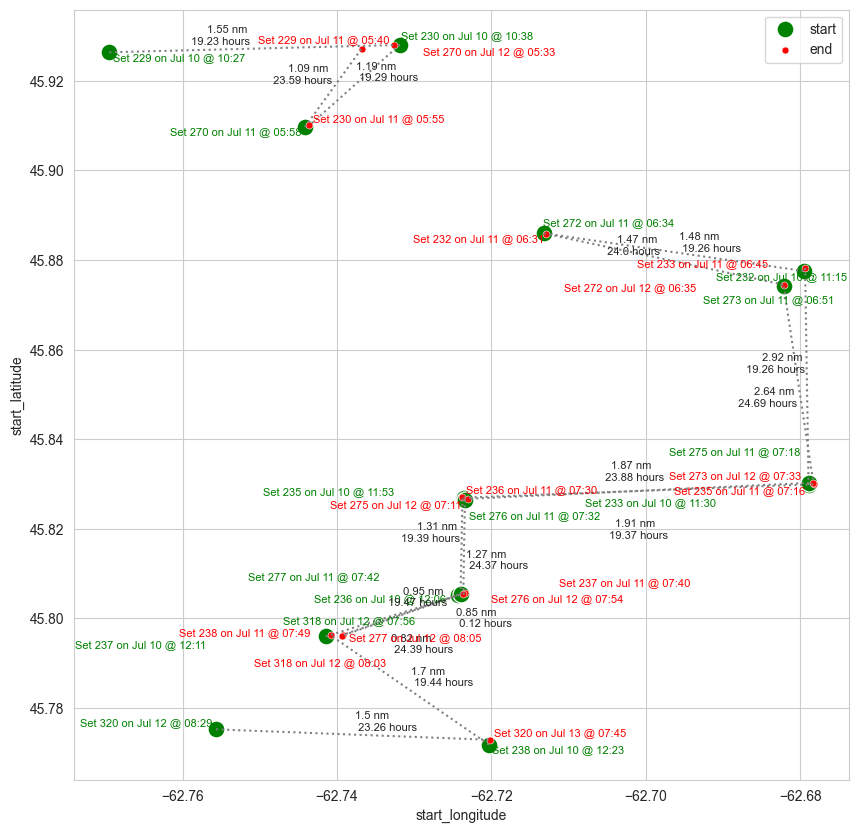

In [74]:
# remove any that have been cleared
cleared_sets = 292, 250, 266
mask = group1["set_number"].apply(lambda x: x not in cleared_sets)
group1 = group1[mask]

# replot the remained sets
plt.figure(figsize=(10, 10))
sns.scatterplot(data=group1, x="start_longitude", y="start_latitude", color="g", label="start", s=150)
sns.scatterplot(data=group1, x="end_longitude", y="end_latitude", color="r", label="end", s=25)
texts = list()
for index, row in group1.iterrows():
    texts.append(
        plt.text(x=row["centroid_longitude"], y=row["centroid_latitude"], font={'size': 8},
                 s=f'{round(row["distance"], 2)} nm \n {round(row["duration"], 2)} hours')
    )
    texts.append(
        plt.text(x=row["start_longitude"], y=row["start_latitude"], color="g", font={'size': 8},
                 s=f'Set {row["set_number"]} on {row["start_date"].strftime("%b %d @ %H:%M")}')
    )
    texts.append(
        plt.text(x=row["end_longitude"], y=row["end_latitude"], color="r", font={'size': 8},
                 s=f'Set {row["set_number"]} on {row["end_date"].strftime("%b %d @ %H:%M")}')
    )

    plt.plot((row["start_longitude"], row["end_longitude"]), (row["start_latitude"], row["end_latitude"]), c="grey", linestyle=":")
adjust_text(texts)

